# Sketchy

Purpose: This notebook provides a walk through the process of retrieving photos of the same class as a hand-drawn sketch with the model proposed in [Doodle to Search: Practical Zero-Shot Sketch-based Image Retrieval](http://dagapp.cvc.uab.es/doodle2search/CVPR2019.pdf). 
Complementary information and studies on the model can be found in [here](http://dagapp.cvc.uab.es/doodle2search/CVPR2019_Supplementery.pdf).

Contrarily to the paper above, we perform here a non-zero shot inference, which means that the classes in training, validation and testing are the same (only sketches and images are different). Moreover, we did not implement all the parts associated with the semantic loss. Further explanation are provided in the model description part.

In [1]:
# Loads the autoreload package into ipython kernel and set it to automatically reload modules
# when they change
%load_ext autoreload
%autoreload 2

#!git clone https://https://github.com/VisiumCH/AMLD-2021-Sketchy.git

#%cd AMLD-2021-Sketchy/

#!make env
#!source env/bin/activate
#!make init
%pwd

'/home/olivier.dietrich/AMLD-2021-Sketchy/notebooks/workshop'

## Package Import

In [2]:
# Python imports
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from glob import glob
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as vision_models
from torch.utils.data import DataLoader
from torchvision import transforms
from sklearn.metrics import average_precision_score


# Codebase imports
from src.data.loader_factory import load_data
from src.data.utils import default_image_loader
from src.models.loss import GradReverse
from src.models.utils import load_checkpoint, normalise_attention

## Model description

### Quick overview

The photo retrieval task aims to return photos that are in the same class as sketches drawn by hand.

Therefore, two encoders are trained: one for photos and one for sketches. Each encoder maps its input (photo or sketch) to an embedding space E.

Then, the embeddings are ranked by similarity based on their euclidean distance in the embedding space and the most similar photos to the sketch  are retrieved.

<img src="images/graph.png">

### Problem Formulation

We have:

$$\begin{align}
& X = \{x_i\}^N_{i=1} 
& l_x : X → C \\
& Y = \{y_i\}^M_{i=1} 
& l_y : Y → C \\
\end{align}$$

with $X$ the set of photos, $Y$ the set of sketches, $C$ the set of all possible categories and $l_x$ and $l_y$ the two labelling functions for photos and sketches respectively.

### Encoder Networks
Given a distance function d(·, ·), the aim of the framework is to learn two embedding functions $Ф : X → R^D$ and $Ψ : Y → R^D$, which respectively map the photo and sketch domain into a common embedding space.

Given two photos $x_1, x_2 ∈ X$ and a sketch $y ∈ Y$, it is expected that the embeddings fulfill the following condition:

$$\begin{align}
& d(Ф(x_1), Ψ(y)) < d(Ф(x2), Ψ(y)), \\
& when \quad l_x(x_1) = l_y(y) \quad and \quad l_x(x_2) ≠ l_y(y) \\
\end{align}$$

meaning that there is a shorter distance when photos and sketch belong to the same class, then when they don't. Here, $d$ is the euclidean distance.

The embedding function $Ф(·)$ and $Ψ(·)$ are defined as two CNNs with attention: VGG 16 networks where the last fully-connected layer has been replaced to match the embedding size E. The attention mechanism helps the system
to localise the important features and is learned end-to-end with the rest of the network. The output of the attention module is computed by $f + f * att$.

### Learning Objectives

The learning objective of the framework combines two losses: the <i>Triplet Loss</i> and the <i>Domain Loss</i>.

Let $\{a, p, n\}$, where $a ∈ Y$, $p ∈ X$ and $n ∈ X$ be respectively the anchor, positive and negative samples during the training and $l_x(p) = l_y(a)$ and $l_x(n) ≠ l_y(a)$.

#### Triplet loss: 
This loss aims to reduce the distance between embedded sketch and image if they belong to the same class and increase it if they belong to different classes.

Defining distance between samples as $δ_+ = ||Ψ(a) − Ф(p)||_2$ and $δ_- = ||Ψ(a) − Ф(n)||_2$ for the positive and negative samples respectively, then, the ranking loss for a particular triplet can be formulated as $λ(δ_+, δ_−) = max\{0, µ+δ_+ −δ_−\}$ where $µ > 0$ is a margin parameter. 


Batch-wise, the loss is defined as:
$$\begin{align}
& L_t = \frac{1}{N}\sum_{i=1}^{N} λ(δ^i_+, δ^i_-) \\
\end{align}$$

 
the order aimed by this loss is $δ_− > δ_+ + µ$, if this is the case, the network is not updated, otherwise, the weights of the network are updated accordingly.

#### Domain loss:
This loss aims to explicitly enforce the mapping of sketch and image samples to a common space.

Given the embedding $Ф(·)$ and $Ψ(·)$, we make use of a Multilayer Perceptron (MLP) as a binary classifier $f(·)$ trying to predict which was the initial domain. Purposefully, in order to create indistinguishable embedding we use a Gradient Reversal Layer (GRL) defined as $R_{λ_d}(·)$, which applies the identity function during the forward pass $R_{λ_d}(x) = x$,
whereas during the backward pass it multiplies the gradients by the meta-parameter $−λ_d$, $\frac{dR_{λ_d}}{dx}= −{λ_d}I$. This operation reverses the sign of the gradient that flows through the CNNs. The meta-parameter $λ_d$ changes from 0 (only trains the classifier but does not update the encoder network) to 1 during the training. 
Here, before the 5th epoch $λ_d=0$, after the 25th $λ_d=1$, and in-between $λ_d(epoch) = (epoch − 5)/20$

With $f : R^D → [0, 1]$ as the MLP function and $e ∈ R^D$ as an embedding coming from the encoders network. We can define the binary cross entropy of one of the samples as $l_t(e) = tlog(f(R_{λ_d}(e))) + (1 − t) log(1 − f(R_{λ_d}(e)))$, where $e$ is the embedding obtained by the encoder network and $t$ is 0 for sketch and 1 for photo. Hence, the domain loss is defined as:

$$\begin{align}
& L_d = \frac{1}{3N}\sum_{i=1}^{N} ( l_0(Ψ(a_i)) + l_1(Ф(p_i)) + l_1(Ф(n_i)) ) \\
\end{align}$$

See the paper for additional information.

## Global Parameters Declaration

In [3]:
class Args:
    dataset = "sketchy"
    data_path = '../../io/data/raw/'
    save = '../../io/models/sktu_copy/'
    load = save + 'checkpoint.pth'
    embeddings_path = save + '00053/default/'
    
    emb_size = 256
    cuda = False
    seed = 42
    
    max_images_test = 10
    training_split = 0.8
    valid_split = 0.1
    batch_size = 10
    prefetch = 2
    attn = True
    margin = 1
    
args = Args()

## The Data

In [4]:
# Note: the code here is simplified, only choose sketchy or quickdraw as dataset.
assert args.dataset in ['sketchy', 'quickdraw']

In [5]:
transform = transforms.Compose([transforms.ToTensor()])

In [6]:
# We will only use the train and test data for this notebook
train_data, [_, _], [test_sk_data, test_im_data], dict_class_to_id = load_data(args, transform)

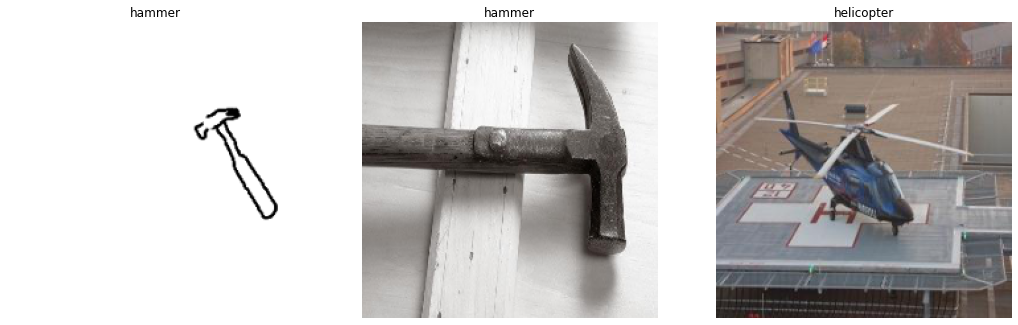

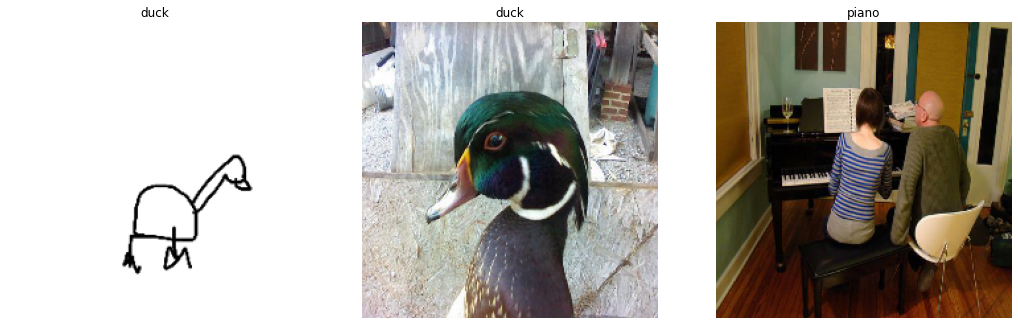

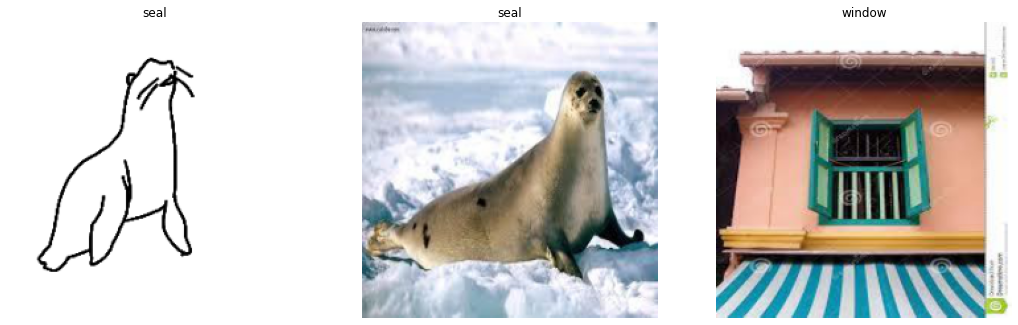

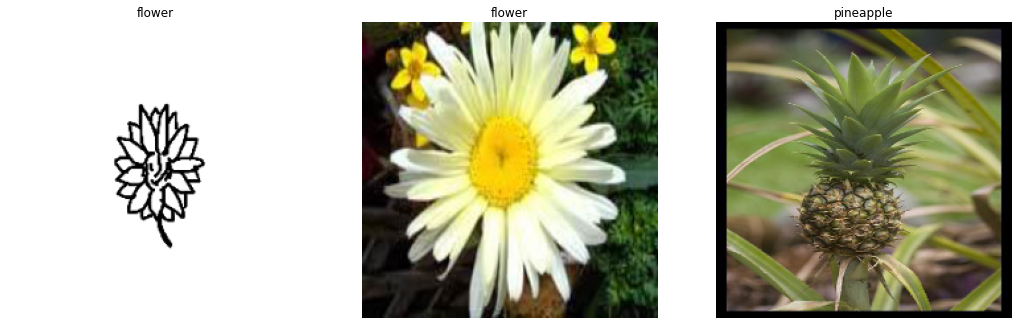

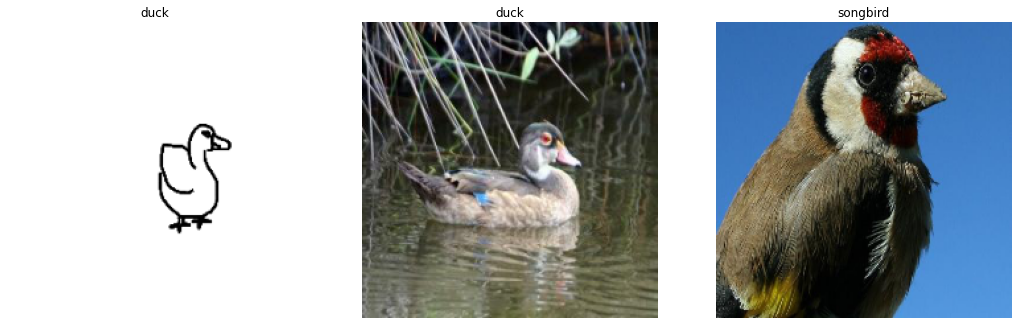

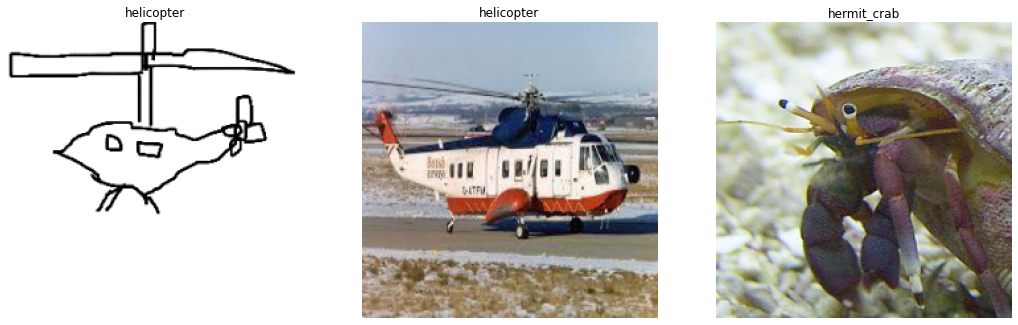

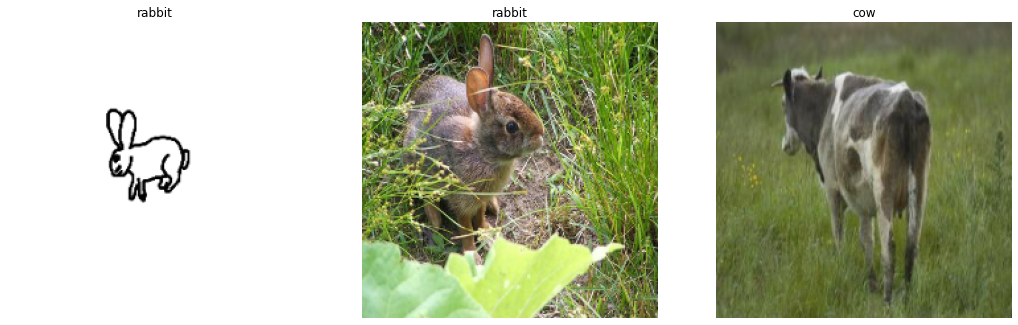

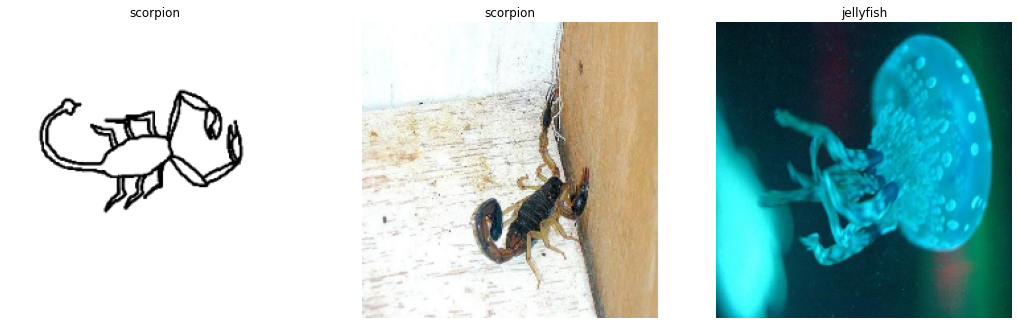

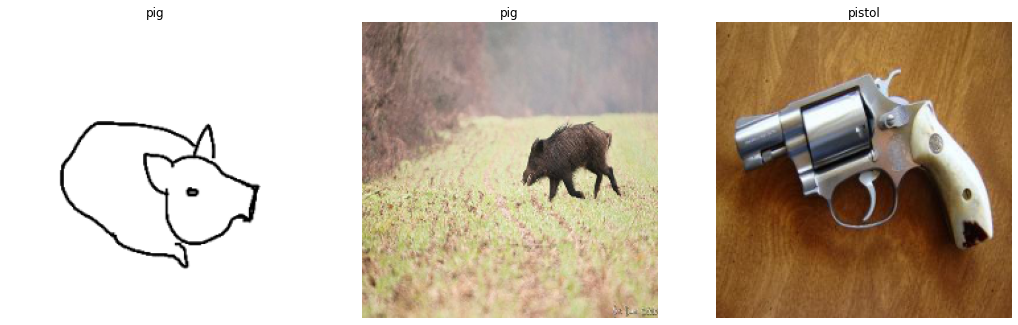

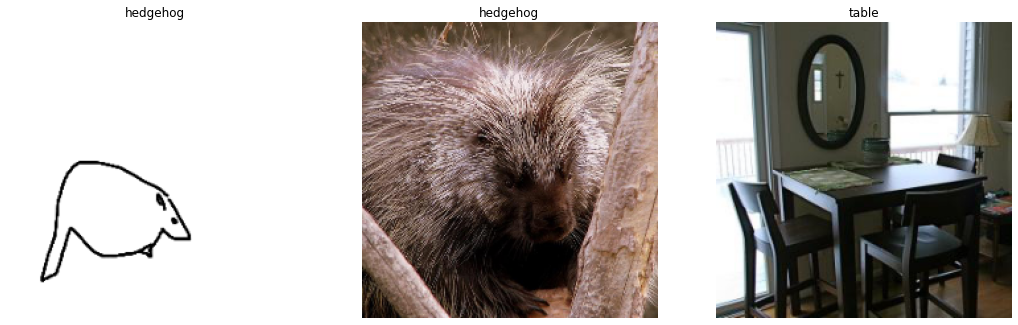

In [7]:
# Let's now load and visualize some training data
train_loader = DataLoader(train_data, batch_size=args.batch_size, shuffle=True,
                          num_workers=args.prefetch, pin_memory=args.cuda, drop_last=True)

# We will work on a single batch
sketchs, positive_images, negative_images, positive_labels, negative_labels = next(iter(train_loader))
positive_labels, negative_labels = positive_labels.numpy(), negative_labels.numpy()

# Reverse dict to go from id to class
dict_id_to_class = {v:k for k,v in dict_class_to_id.items()}

for i in range(args.batch_size):
    fig, ax = plt.subplots(1, 3, figsize=(18,6))
    
    ax[0].imshow(sketchs[i].permute(1,2,0).numpy())
    ax[0].set_title(dict_id_to_class[positive_labels[i]])
    ax[0].axis("off")

    ax[1].imshow(positive_images[i].permute(1,2,0).numpy())
    ax[1].set_title(dict_id_to_class[positive_labels[i]])
    ax[1].axis("off")

    ax[2].imshow(negative_images[i].permute(1,2,0).numpy())
    ax[2].set_title(dict_id_to_class[negative_labels[i]])
    ax[2].axis("off")
    
plt.show()

# Training
## The Model

In [8]:
class AttentionModel(nn.Module):
    def __init__(self, hidden_layer=380):
        super(AttentionModel, self).__init__()

        self.attn_hidden_layer = hidden_layer
        self.net = nn.Sequential(nn.Conv2d(512, self.attn_hidden_layer, kernel_size=1),
                                 nn.Conv2d(self.attn_hidden_layer, 1, kernel_size=1))

    def forward(self, x):
        attn_mask = self.net(x)
        attn_mask = attn_mask.view(attn_mask.size(0), -1)
        attn_mask = nn.Softmax(dim=1)(attn_mask)
        attn_mask = attn_mask.view(attn_mask.size(0), 1, x.size(2), x.size(3))
        x_attn = x * attn_mask
        x = x + x_attn
        return x, attn_mask
    
class EncoderCNN(nn.Module):
    def __init__(self, out_size=300, pretrained=True, attention=True):
        super(EncoderCNN, self).__init__()
        # Embedd images in a 1000 space
        vgg_aux = vision_models.vgg16_bn(pretrained)
        self.cnn_features = vgg_aux.features

        # Attention model
        self.attention = attention

        self.attn = AttentionModel()

        self.map = vgg_aux.classifier
        self.map._modules['6'] = nn.Linear(4096, out_size)

    def forward(self, im):
        x = self.cnn_features(im)  # Size (BS x 512 x 7 x 7)

        if self.attention:
            x, attn_mask = self.attn(x)  # Size (BS x 512)

        x = x.view(x.size(0), -1)

        x = self.map(x)
        if not self.attention:
            attn_mask = torch.zeros(7, 7)
        return x, attn_mask

In [9]:
# We create the model
im_net = EncoderCNN(out_size=args.emb_size, attention=args.attn)
sk_net = EncoderCNN(out_size=args.emb_size, attention=args.attn)

## Losses

To work with the losses, let's first get the embeddings of the images from the first batch.

In [10]:
im_net.train()
sk_net.train()
torch.set_grad_enabled(True)

checkpoint = load_checkpoint(args.load)
im_net.load_state_dict(checkpoint["im_state"])
sk_net.load_state_dict(checkpoint["sk_state"])

positive_image_embeddings, _ = im_net(positive_images)
negative_image_embeddings, _ = im_net(negative_images)
sketch_embeddings, _ = sk_net(sketchs)

=> loading model '../../io/models/sktu_copy/checkpoint.pth'
=> loaded model '../../io/models/sktu_copy/checkpoint.pth' (epoch 49, map 0.3094873427878774)


### Triplet loss

**TODO**: Implement the triplet loss step by step based on the formulas provided in the Learning Objectives' Triplet Loss.

*N.B*: This loss is implemented in PyTorch as nn.TripletMarginLoss

In [11]:
def calculate_triplet_loss(sketch_embeddings, positive_image_embeddings, negative_image_embeddings):
    
    triplet_loss = ... # Implement me !
    return triplet_loss

In [12]:
def calculate_triplet_loss_solution(sketch_embeddings, positive_image_embeddings, negative_image_embeddings):
    
    # Compute distance for positive and negative samples
    delta_plus = torch.linalg.norm(sketch_embeddings - positive_image_embeddings, axis=1, ord=2)
    delta_minus = torch.linalg.norm(sketch_embeddings - negative_image_embeddings, axis=1, ord=2)

    # Calculate difference (with margin) and take the max(0, _lambda)
    _lambda = args.margin + delta_plus - delta_minus
    _lambda[_lambda<0] = 0

    # Calculate loss batch-wise
    triplet_loss = torch.mean(_lambda)
    return triplet_loss

In [13]:
triplet_loss = calculate_triplet_loss_solution(sketch_embeddings, positive_image_embeddings, negative_image_embeddings)
triplet_loss

tensor(0.1799, grad_fn=<MeanBackward0>)

**Question**: Theoretically, would the network be updated for any of these samples ? 

**Answer**: when true, no update and when false update.

Let's verify this function with the embeddings from one batch.

### Domain Loss

For this loss, we already have implemented the reverse gradient and the loss from the binary classifier (MLP)

**TODO**: Implement the domain loss (see Learning Objectives: Domain Loss)

In [14]:
def grad_reverse(x, lambd=0.5):
    '''
    Forward pass R(x) = x
    Backward pass R(X) = -λx
    '''
    return GradReverse.apply(x, lambd)

class DomainLoss(nn.Module):
    '''Ensures that embeddings belong to the same space'''

    def __init__(self, input_size=256, hidden_size=64):
        super(DomainLoss, self).__init__()
        self.input_size = input_size
        # self.map = nn.Linear(self.input_size, 1)
        self.map = nn.Sequential(
            nn.Linear(self.input_size, hidden_size),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(True),
            nn.Linear(hidden_size, 1),
        )

    def forward(self, input, target):
        input = self.map(input)
        input = torch.sigmoid(input).squeeze()
        return F.binary_cross_entropy(input, target)

In [15]:
def get_lambda_d(epoch):
    lambda_d = ... # Implement me!
    return lambda_d

def calculate_domain_loss(sketch_embeddings, positive_image_embeddings, negative_image_embeddings, epoch):
    # Get Lambda
    lambda_d = get_lambda_d(epoch)
    
    # Outputs the binary cross entropy between the input and the target
    domain_loss = DomainLoss(input_size=args.emb_size)

    # Hint: 1. create the target for the classification between sketch and images.
    #       2. add the backward pass of the binary crossentropy between inputs and targets.
    
    loss_dom = ... # Implement me !
    return loss_dom

In [16]:
def get_lambda_d_solution(epoch):
    
    lambda_d = (epoch-5)/20
    lambda_d = np.clip(lambda_d, 0, 1)
    return lambda_d

def calculate_domain_loss_solution(sketch_embeddings, positive_image_embeddings, negative_image_embeddings, epoch):
    ''' Correction to remove '''
    # Get Lambda
    lambda_d = get_lambda_d_solution(epoch=10)
    
    # Outputs the binary cross entropy between the input and the target
    domain_loss = DomainLoss(input_size=args.emb_size)

    targetSK = torch.zeros(args.batch_size)
    targetIM = torch.ones(args.batch_size)

    loss_dom_sk = domain_loss(grad_reverse(sketch_embeddings, lambd=lambda_d), targetSK)
    loss_dom_pos_im = domain_loss(grad_reverse(positive_image_embeddings, lambd=lambda_d), targetIM)
    loss_dom_neg_im = domain_loss(grad_reverse(negative_image_embeddings, lambd=lambda_d), targetIM)
    loss_dom = torch.mean(loss_dom_sk + loss_dom_pos_im + loss_dom_neg_im)
    return loss_dom

In [17]:
loss_dom = calculate_domain_loss_solution(sketch_embeddings, positive_image_embeddings, negative_image_embeddings, epoch=10)
loss_dom

tensor(2.0286, grad_fn=<MeanBackward0>)

### Final Loss

**TODO**: And now get the final loss weighting the domain and the triplet loss!

In [18]:
def calculate_final_loss(
    sketch_embeddings,
    positive_image_embeddings,
    negative_image_embeddings,
    epoch,
    w_triplet = 1,
    w_domain = 1
):
    
    loss = ... # Implement me !
    return loss

In [19]:
def calculate_final_loss_solution(
    sketch_embeddings,
    positive_image_embeddings,
    negative_image_embeddings,
    epoch,
    w_triplet = 1,
    w_domain = 1
):
    triplet_loss = calculate_triplet_loss_solution(sketch_embeddings, positive_image_embeddings, negative_image_embeddings)
    domain_loss = calculate_domain_loss_solution(sketch_embeddings, positive_image_embeddings, negative_image_embeddings, epoch)
    loss = w_triplet * triplet_loss + w_domain * domain_loss
    return loss

In [20]:
loss = calculate_final_loss_solution(sketch_embeddings, positive_image_embeddings, negative_image_embeddings, epoch=10)
loss

tensor(2.2163, grad_fn=<AddBackward0>)

# Testing

We will now see how to assess our model's performance and retrieve the images that are the most likely to correspond to a sketch.

In [21]:
im_net.eval()
sk_net.eval()
torch.set_grad_enabled(False);

## Performance
### Compute embeddings

As you can imagine, to performe the inference, one first need to compute the embeddings for all the images. As this is a long and quite straightforward process, we already have done it for you and saved them in a .npy file. Here is the function to load them.

In [22]:
def load_precomputed_embeddings(args, dataset_type):
    
    assert dataset_type in ["test", "valid"]

    precomputed_embeddings_path = os.path.join(args.save, "precomputed_embeddings")
    embeddings_path = os.path.join(precomputed_embeddings_path, f"{args.dataset}_{dataset_type}_array.npy")
    meta_path = os.path.join(precomputed_embeddings_path, f"{args.dataset}_{dataset_type}_meta.csv")

    if not os.path.exists(embeddings_path):
        raise FileNotFoundError("The embeddings have not been precomputed for this dataset yet.")

    with open(embeddings_path, "rb") as f:
        images_embeddings = np.load(f)
    df = pd.read_csv(meta_path, sep=" ")
    
    images_fnames, images_classes = df["fnames"].to_list(), df["classes"].to_list()
    
    return images_embeddings, images_classes, images_fnames

In [23]:
images_embeddings, images_classes, images_fnames = load_precomputed_embeddings(args, dataset_type="test")
print(images_embeddings.shape)

(7308, 256)


Now we can compute these embeddings for the sketches as well. Here is the function that we used before to compute the embeddings. It takes a data loader and a model as parameter and returns the embeddings, along with the path and class of each image/sketch. You can also add the parameters max_num_batches and num_first_batch in the args, which will respectively stop the iteration when a maximum number of batch has been seen and skip the first batches while looping.

In [25]:
def compute_embeddings(data_loader, model, args):

    if args.cuda:
        model = model.cuda()

    total = args.__dict__.get("max_num_batches", len(data_loader))
    num_first_batch = args.__dict__.get("num_first_batch", 0)
    for i, (image, fname, target) in enumerate(tqdm(data_loader, total=total)):

        # Ignore first batches and stop when reaching max number
        if i < num_first_batch:
            continue
        if i >= total + num_first_batch :
            break

        # Data to Variable
        if args.cuda:
            image, target = image.cuda(), target.cuda()

        # Process
        out_features, _ = model(image)

        if args.cuda:
            out_features = out_features.cpu().data.numpy()
            target = target.cpu().data.numpy()
        else:
            out_features = out_features.detach().numpy()

        if i == num_first_batch:
            fnames = [fname]
            embeddings = out_features
            classes = target
        else:
            fnames.append(fnames)
            embeddings = np.concatenate((embeddings, out_features), axis=0)
            classes = np.concatenate((classes, target), axis=0)
            
    # Save
    ...

    return embeddings, classes, fnames

As it is quite slow, we only compute 300 sketches, which should be enough to assess our model performance. Feel free to increase this number (as long as your memory holds 😉)

In [26]:
# We compute 10*30=300 sketches embeddings
args.batch_size_test = 30
args.max_num_batches = 10
args.num_first_batch  = 0

# Get the DataLoader
sk_test_loader = DataLoader(test_sk_data, batch_size=args.batch_size_test,
                       num_workers=args.prefetch, pin_memory=True)


sketch_test_embeddings, sketch_test_classes, sketch_test_fnames = compute_embeddings(sk_test_loader, sk_net, args)

100%|██████████| 10/10 [00:51<00:00,  5.13s/it]


In [27]:
print(sketch_test_embeddings.shape)

(300, 256)


### Similarity

Now that we have both the embeddings for the images and the sketches, we can perform the inference by computing the similarity between them in the embeddings space. we define the similarity by the following simple function (with the distance being the Euclidian distance between both embeddings): $$similarity = \frac{1}{1 + distance}$$

In [28]:
def get_similarity(im_embeddings, sk_embeddings):
    '''
    Computes images and sketch similarity in the feature space.
    The distance is computed as the euclidean distance. 
    Here, we want similarity = 1/(1 + distance)
    Args:
        - im_embeddings: embeddings of the images [MxE]
        - sk_embeddings: embeddings of the sketches [NxE]
    Return:
        - similarity: similarity value between images and sketches embeddings [NxM]
    '''
    
    similarity = ... # Implement me !
    return similarity


def get_similarity_solution(im_embeddings, sk_embeddings):

    from scipy.spatial.distance import cdist
    
    similarity = 1/(1 + cdist(sk_embeddings, im_embeddings, 'euclidean'))
    return similarity

In [29]:
similarity = get_similarity_solution(images_embeddings, sketch_test_embeddings)
similarity.shape

(300, 7308)

We check the labels of the loaded sketches and embeddings. 1 where the label and sketch match and 0 otherwise.

In [30]:
def compare_classes(class_im, class_sk):
    '''
    Compare classes of images and sketches
    Args:
        - class_im: list of classes of the images [M]
        - class_sk: list of classes of the sketches [N]
    Return:
        - array [MxN] of 1 where the image and sketch belong to the same class and 0 elsewhere
    '''
    class_sk = np.expand_dims(class_sk, axis=1)
    class_im = np.expand_dims(class_im, axis=0)
    class_matches = ... # Implement me!
    return class_matches


def compare_classes_solution(class_im, class_sk):
    ''' Correction to remove '''
    class_sk = np.expand_dims(class_sk, axis=1)
    class_im = np.expand_dims(class_im, axis=0)
    class_matches = (class_sk == class_im)*1
    return class_matches

In [31]:
class_matches = compare_classes_solution(images_classes, sketch_test_classes)
class_matches

array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

We sort the images based on their similarity with sketches (most similar to least similar)

In [37]:
similarity.squeeze()

(300, 7308)

In [38]:
arg_sorted_sim = (-similarity).argsort()
sorted_similarity = []  # list of similarity values ordered by similarity (most to least similar)
sorted_class = []       # list of class match ordered by similarity (0 if different, 1 if same)
for index in range(0, arg_sorted_sim.shape[0]):
    sorted_similarity.append(similarity[index, arg_sorted_sim[index, :]])
    sorted_class.append(class_matches[index, arg_sorted_sim[index, :]])

sorted_similarity = np.array(sorted_similarity)
sorted_class_matches = np.array(sorted_class)

In [39]:
sorted_similarity

array([[0.1098659 , 0.1097155 , 0.10953358, ..., 0.04201812, 0.04122122,
        0.03995343],
       [0.10058508, 0.09928954, 0.09857327, ..., 0.04202428, 0.04180339,
        0.04037085],
       [0.10639023, 0.105399  , 0.10511411, ..., 0.0444835 , 0.04357615,
        0.04182725],
       ...,
       [0.12355709, 0.12331319, 0.12105083, ..., 0.05132198, 0.05085099,
        0.04819512],
       [0.12904726, 0.12764015, 0.12616322, ..., 0.04740439, 0.04719319,
        0.04462652],
       [0.13251434, 0.13079145, 0.13047431, ..., 0.0478542 , 0.04705165,
        0.04446518]])

**TODO** Compute the mAP (mean average precision) and Precision@200 of the results.

In [90]:
# TODO
# Compute the mean average precision of all results
# Hint: you can use sklearn function average_precision_score
map_ = ... # Implement me!
map_ = average_precision_score(sorted_class_matches, sorted_similarity) # Correction
print(f'The mean average precision of all samples is {np.round(map_, 4)}.')

/home/olivier.dietrich/AMLD-2021-Sketchy/env/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/olivier.dietrich/AMLD-2021-Sketchy/env/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/olivier.dietrich/AMLD-2021-Sketchy/env/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/olivier.dietrich/AMLD-2021-Sketchy/env/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/olivier.dietrich/AMLD-2021-Sketchy/env/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/olivier.dietrich/AMLD-2021-Sketchy/env/lib/python3.7/s

/home/olivier.dietrich/AMLD-2021-Sketchy/env/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/olivier.dietrich/AMLD-2021-Sketchy/env/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/olivier.dietrich/AMLD-2021-Sketchy/env/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/olivier.dietrich/AMLD-2021-Sketchy/env/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/olivier.dietrich/AMLD-2021-Sketchy/env/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/olivier.dietrich/AMLD-2021-Sketchy/env/lib/python3.7/s

/home/olivier.dietrich/AMLD-2021-Sketchy/env/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/olivier.dietrich/AMLD-2021-Sketchy/env/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/olivier.dietrich/AMLD-2021-Sketchy/env/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/olivier.dietrich/AMLD-2021-Sketchy/env/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/olivier.dietrich/AMLD-2021-Sketchy/env/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/olivier.dietrich/AMLD-2021-Sketchy/env/lib/python3.7/s

/home/olivier.dietrich/AMLD-2021-Sketchy/env/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/olivier.dietrich/AMLD-2021-Sketchy/env/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/olivier.dietrich/AMLD-2021-Sketchy/env/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/olivier.dietrich/AMLD-2021-Sketchy/env/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/olivier.dietrich/AMLD-2021-Sketchy/env/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/olivier.dietrich/AMLD-2021-Sketchy/env/lib/python3.7/s

/home/olivier.dietrich/AMLD-2021-Sketchy/env/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/olivier.dietrich/AMLD-2021-Sketchy/env/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/olivier.dietrich/AMLD-2021-Sketchy/env/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/olivier.dietrich/AMLD-2021-Sketchy/env/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/olivier.dietrich/AMLD-2021-Sketchy/env/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/olivier.dietrich/AMLD-2021-Sketchy/env/lib/python3.7/s

/home/olivier.dietrich/AMLD-2021-Sketchy/env/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/olivier.dietrich/AMLD-2021-Sketchy/env/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/olivier.dietrich/AMLD-2021-Sketchy/env/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/olivier.dietrich/AMLD-2021-Sketchy/env/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/olivier.dietrich/AMLD-2021-Sketchy/env/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/olivier.dietrich/AMLD-2021-Sketchy/env/lib/python3.7/s

/home/olivier.dietrich/AMLD-2021-Sketchy/env/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/olivier.dietrich/AMLD-2021-Sketchy/env/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/olivier.dietrich/AMLD-2021-Sketchy/env/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/olivier.dietrich/AMLD-2021-Sketchy/env/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/olivier.dietrich/AMLD-2021-Sketchy/env/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/olivier.dietrich/AMLD-2021-Sketchy/env/lib/python3.7/s

/home/olivier.dietrich/AMLD-2021-Sketchy/env/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/olivier.dietrich/AMLD-2021-Sketchy/env/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/olivier.dietrich/AMLD-2021-Sketchy/env/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/olivier.dietrich/AMLD-2021-Sketchy/env/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/olivier.dietrich/AMLD-2021-Sketchy/env/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/olivier.dietrich/AMLD-2021-Sketchy/env/lib/python3.7/s

/home/olivier.dietrich/AMLD-2021-Sketchy/env/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/olivier.dietrich/AMLD-2021-Sketchy/env/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/olivier.dietrich/AMLD-2021-Sketchy/env/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/olivier.dietrich/AMLD-2021-Sketchy/env/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/olivier.dietrich/AMLD-2021-Sketchy/env/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/olivier.dietrich/AMLD-2021-Sketchy/env/lib/python3.7/s

/home/olivier.dietrich/AMLD-2021-Sketchy/env/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/olivier.dietrich/AMLD-2021-Sketchy/env/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/olivier.dietrich/AMLD-2021-Sketchy/env/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/olivier.dietrich/AMLD-2021-Sketchy/env/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/olivier.dietrich/AMLD-2021-Sketchy/env/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/olivier.dietrich/AMLD-2021-Sketchy/env/lib/python3.7/s

/home/olivier.dietrich/AMLD-2021-Sketchy/env/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/olivier.dietrich/AMLD-2021-Sketchy/env/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/olivier.dietrich/AMLD-2021-Sketchy/env/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/olivier.dietrich/AMLD-2021-Sketchy/env/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/olivier.dietrich/AMLD-2021-Sketchy/env/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/olivier.dietrich/AMLD-2021-Sketchy/env/lib/python3.7/s

/home/olivier.dietrich/AMLD-2021-Sketchy/env/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/olivier.dietrich/AMLD-2021-Sketchy/env/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/olivier.dietrich/AMLD-2021-Sketchy/env/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/olivier.dietrich/AMLD-2021-Sketchy/env/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/olivier.dietrich/AMLD-2021-Sketchy/env/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/olivier.dietrich/AMLD-2021-Sketchy/env/lib/python3.7/s

/home/olivier.dietrich/AMLD-2021-Sketchy/env/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/olivier.dietrich/AMLD-2021-Sketchy/env/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/olivier.dietrich/AMLD-2021-Sketchy/env/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/olivier.dietrich/AMLD-2021-Sketchy/env/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/olivier.dietrich/AMLD-2021-Sketchy/env/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/olivier.dietrich/AMLD-2021-Sketchy/env/lib/python3.7/s

/home/olivier.dietrich/AMLD-2021-Sketchy/env/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/olivier.dietrich/AMLD-2021-Sketchy/env/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/olivier.dietrich/AMLD-2021-Sketchy/env/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/olivier.dietrich/AMLD-2021-Sketchy/env/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/olivier.dietrich/AMLD-2021-Sketchy/env/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/olivier.dietrich/AMLD-2021-Sketchy/env/lib/python3.7/s

/home/olivier.dietrich/AMLD-2021-Sketchy/env/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/olivier.dietrich/AMLD-2021-Sketchy/env/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/olivier.dietrich/AMLD-2021-Sketchy/env/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/olivier.dietrich/AMLD-2021-Sketchy/env/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/olivier.dietrich/AMLD-2021-Sketchy/env/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/olivier.dietrich/AMLD-2021-Sketchy/env/lib/python3.7/s

/home/olivier.dietrich/AMLD-2021-Sketchy/env/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/olivier.dietrich/AMLD-2021-Sketchy/env/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/olivier.dietrich/AMLD-2021-Sketchy/env/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/olivier.dietrich/AMLD-2021-Sketchy/env/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/olivier.dietrich/AMLD-2021-Sketchy/env/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/olivier.dietrich/AMLD-2021-Sketchy/env/lib/python3.7/s

/home/olivier.dietrich/AMLD-2021-Sketchy/env/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/olivier.dietrich/AMLD-2021-Sketchy/env/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/olivier.dietrich/AMLD-2021-Sketchy/env/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/olivier.dietrich/AMLD-2021-Sketchy/env/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/olivier.dietrich/AMLD-2021-Sketchy/env/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/olivier.dietrich/AMLD-2021-Sketchy/env/lib/python3.7/s

/home/olivier.dietrich/AMLD-2021-Sketchy/env/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/olivier.dietrich/AMLD-2021-Sketchy/env/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/olivier.dietrich/AMLD-2021-Sketchy/env/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/olivier.dietrich/AMLD-2021-Sketchy/env/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/olivier.dietrich/AMLD-2021-Sketchy/env/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/olivier.dietrich/AMLD-2021-Sketchy/env/lib/python3.7/s

/home/olivier.dietrich/AMLD-2021-Sketchy/env/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/olivier.dietrich/AMLD-2021-Sketchy/env/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/olivier.dietrich/AMLD-2021-Sketchy/env/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/olivier.dietrich/AMLD-2021-Sketchy/env/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/olivier.dietrich/AMLD-2021-Sketchy/env/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/olivier.dietrich/AMLD-2021-Sketchy/env/lib/python3.7/s

/home/olivier.dietrich/AMLD-2021-Sketchy/env/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/olivier.dietrich/AMLD-2021-Sketchy/env/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/olivier.dietrich/AMLD-2021-Sketchy/env/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/olivier.dietrich/AMLD-2021-Sketchy/env/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/olivier.dietrich/AMLD-2021-Sketchy/env/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/olivier.dietrich/AMLD-2021-Sketchy/env/lib/python3.7/s

/home/olivier.dietrich/AMLD-2021-Sketchy/env/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/olivier.dietrich/AMLD-2021-Sketchy/env/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/olivier.dietrich/AMLD-2021-Sketchy/env/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/olivier.dietrich/AMLD-2021-Sketchy/env/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/olivier.dietrich/AMLD-2021-Sketchy/env/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/olivier.dietrich/AMLD-2021-Sketchy/env/lib/python3.7/s

/home/olivier.dietrich/AMLD-2021-Sketchy/env/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/olivier.dietrich/AMLD-2021-Sketchy/env/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/olivier.dietrich/AMLD-2021-Sketchy/env/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/olivier.dietrich/AMLD-2021-Sketchy/env/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/olivier.dietrich/AMLD-2021-Sketchy/env/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/olivier.dietrich/AMLD-2021-Sketchy/env/lib/python3.7/s

The mean average precision of all samples is nan.


/home/olivier.dietrich/AMLD-2021-Sketchy/env/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/olivier.dietrich/AMLD-2021-Sketchy/env/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/olivier.dietrich/AMLD-2021-Sketchy/env/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/olivier.dietrich/AMLD-2021-Sketchy/env/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/olivier.dietrich/AMLD-2021-Sketchy/env/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/olivier.dietrich/AMLD-2021-Sketchy/env/lib/python3.7/s

In [113]:
# TODO
# Compute the mean average precision of the 200 first results
map_200 = ... # Implement me!
map_200 = average_precision_score(sorted_class_matches[:, 0:200], sorted_similarity[:, 0:200]) # Correction
print(f'The mean average precision of the 200 most similar is {np.round(map_200, 4)}.')

The mean average precision of the 200 most similar is 0.2496.


In [124]:
# TODO
# Compute the Precision@200 (meaning the precision at the place 200th)
prec_200 =... # Implement me!
prec_200 = np.mean(sorted_class_matches[:, 200]) # Correction
print(f'The precision of the 200 most similar is {np.round(prec_200, 4)}.')

The precision of the 200 most similar is 0.0367.


## Visualize results

You now have all the necessary data to code the function to perform an inference on a sketch and retrieve the closest images ! 

**TODO**
First plot the original sketch. Then the superposed sketch and the attention heatmap and finally the NUM_CLOSEST closest images with their labels in the title. With NUM_CLOSEST = 5, it should look like this:

<img src="images/ant_and_attention.png">
<img src="images/ant_best_guess.png">

In [40]:
# 0. constants
NUM_CLOSEST = 5 # Play with this parameter
sketch_root = '../../io/data/raw/Quickdraw/sketches/' # Directory containing all the sketches

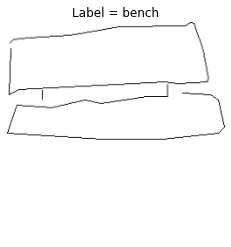

In [41]:
# 1. Pick a sketch (either from all existing ones or from the following selected list)
# sketch_fnames = glob(os.path.join(sketch_root, "**/*.png"), recursive=True)
sketch_fnames = ['ant/4531454526619648.png', 'alarm_clock/4506026491510784.png', 'axe/4505398503538688.png', 
                 'apple/4505772249579520.png', 'banana/4512982459482112.png', 'bee/4504274916605952.png', 
                 'bench/4506543531753472.png', 'cake/4507078863355904.png', 'cactus/4506460186738688.png',
                 'camel/4507169137360896.png', 'campfire/4505920430145536.png', 'car/4504613682151424.png', 
                 'church/4504994524954624.png', 'crocodilian/4505874796118016.png', 'dog/4505656939773952.png']
sketch_fnames = [os.path.join(sketch_root, fname) for fname in sketch_fnames]
sketch_fname = np.random.choice(sketch_fnames, 1)[0]

# Load the sketch from its path and transform it into good format
sketch = default_image_loader(sketch_fname) # basically load and resize the image
sketch = transform(sketch) # apply transform
sketch = sketch.unsqueeze(0) # expand because no batch

# Quick visualization
plt.imshow(sketch[0].permute(1,2,0))
plt.title(f"Label = {sketch_fname.split('/')[-2]}")
plt.axis('off')
plt.show()

In [42]:
# 2. Compute the embeddings and the attention map
sketch_embedding, sketch_attention = 0,0 #... # Implement me !
sketch_embedding, sketch_attention = sk_net(sketch) # TODO: DELETE solution
sketch_attention = normalise_attention(sketch_attention, sketch) # Get the attention values normalized and sized as the sketch

In [43]:
similarity.squeeze().shape

(300, 7308)

In [61]:
# 3. Compute similarity with image embeddings and sort index from
similarity = ... # Implement me ! (Done before)
arg_sorted_sim = ... # Implement me !

similarity = get_similarity_solution(sketch_embedding, images_embeddings)# TODO: DELETE solution
similarity = similarity.squeeze()
arg_sorted_sim = (-similarity).argsort()

In [63]:
# 4. Keep only the NUM_CLOSEST ones
sorted_fnames = ...
sorted_labels = ...

sorted_fnames = [images_fnames[i] for i in arg_sorted_sim[0: NUM_CLOSEST + 1]]
sorted_labels = [images_classes[i] for i in arg_sorted_sim[0: NUM_CLOSEST + 1]]

In [64]:
# 5. Load images and get labels
closest_images = [default_image_loader('../../' + fname) for fname in sorted_fnames]
closest_labels = [dict_id_to_class[label] for label in sorted_labels]

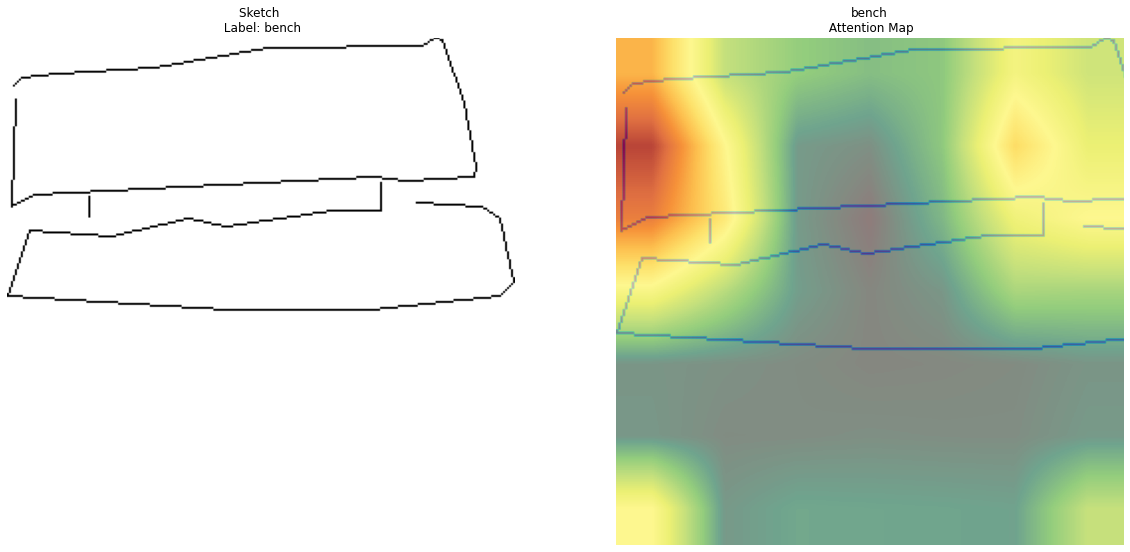

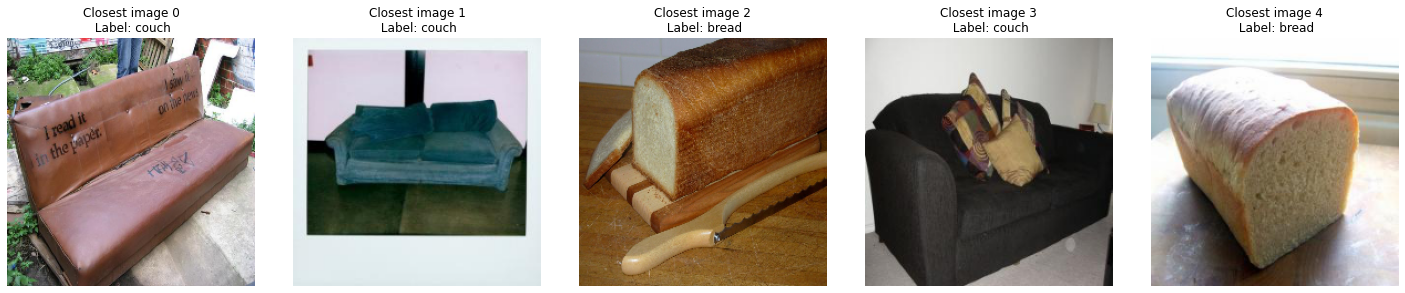

In [65]:
# 6. Plot

# Plot sketch and attention map
fig1, ax1 = plt.subplots(1, 2, figsize=(NUM_CLOSEST*4,NUM_CLOSEST*2))

sk = plt.imread(sketch_fname)
ax1[0].imshow(sk, cmap="gray")
ax1[0].set(title="Sketch \n Label: " + sketch_fname.split("/")[-2])
ax1[0].axis("off")

# We remove unecessary dimension from the heat map for the plot
heat_map = sketch_attention.squeeze()
ax1[1].imshow(sk)
ax1[1].imshow(255 * heat_map, alpha=0.7, cmap="Spectral_r")
ax1[1].set(title=sketch_fname.split("/")[-2] + "\n Attention Map")
ax1[1].axis("off")
fig1.savefig("images/ant_and_attention.png")

fig2, ax2 = plt.subplots(1, NUM_CLOSEST, figsize=(NUM_CLOSEST*4,4))
for i in range(NUM_CLOSEST):
    ax2[i].imshow(closest_images[i])
    ax2[i].set(title='Closest image ' + str(i) + '\n Label: ' + closest_labels[i])
    ax2[i].axis('off')
fig2.savefig("images/ant_best_guess.png")

#plt.subplots_adjust(wspace=0.25, hspace=-0.35)
plt.tight_layout()
plt.show()

## BONUS:

Play around with the web app.
 <img src="images/drawing.png"> 
 <img src="images/embeddings.png"> 